In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from colorama import Fore

In [2]:
import os
for dirname, _, filenames in os.walk('nail-disease-detection-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

nail-disease-detection-dataset\data\train\Acral_Lentiginous_Melanoma\1124-Subungual_Melanoma-642x361-slide3_jpg.rf.0dac8bb63db59e791970223a68db4b3e.jpg
nail-disease-detection-dataset\data\train\Acral_Lentiginous_Melanoma\1124-Subungual_Melanoma-642x361-slide3_jpg.rf.20c5952ae446e61a018ac2e98609f278.jpg
nail-disease-detection-dataset\data\train\Acral_Lentiginous_Melanoma\1124-Subungual_Melanoma-642x361-slide3_jpg.rf.3de4faf4d64a0103c78ab6b6224a21d5.jpg
nail-disease-detection-dataset\data\train\Acral_Lentiginous_Melanoma\4229e494114681c808066e262f2f82ad1c89676d_jpg.rf.9d151d7348b779653542fc6cd8cfb04f.jpg
nail-disease-detection-dataset\data\train\Acral_Lentiginous_Melanoma\4229e494114681c808066e262f2f82ad1c89676d_jpg.rf.c06c1d1f4666c86b4d9c077d67cf65d6.jpg
nail-disease-detection-dataset\data\train\Acral_Lentiginous_Melanoma\4229e494114681c808066e262f2f82ad1c89676d_jpg.rf.e50fbd6607bf6a1c7dd7a3804e808c92.jpg
nail-disease-detection-dataset\data\train\Acral_Lentiginous_Melanoma\4494_jpg.rf.3

In [3]:
train_path = 'nail-disease-detection-dataset/data/train'
validation_path = 'nail-disease-detection-dataset/data/validation'

In [4]:
train_folders = [f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))]
print("Folders in the training dataset path:", train_folders)

validation_folders = [f for f in os.listdir(validation_path) if os.path.isdir(os.path.join(validation_path, f))]
print("Folders in the validation dataset path:", validation_folders)

Folders in the training dataset path: ['Acral_Lentiginous_Melanoma', 'blue_finger', 'clubbing', 'Healthy_Nail', 'Onychogryphosis', 'pitting']
Folders in the validation dataset path: ['Acral_Lentiginous_Melanoma', 'blue_finger', 'clubbing', 'Healthy_Nail', 'Onychogryphosis', 'pitting']


In [5]:
folders = ['blue_finger', 'Acral_Lentiginous_Melanoma', 'pitting', 'Onychogryphosis', 'clubbing', 'Healthy_Nail']

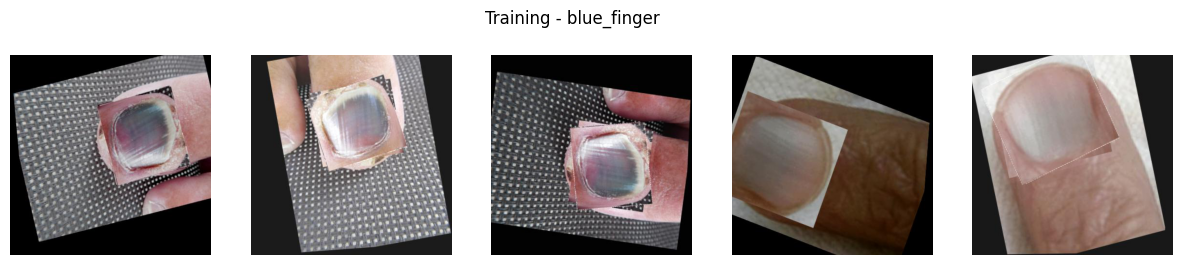

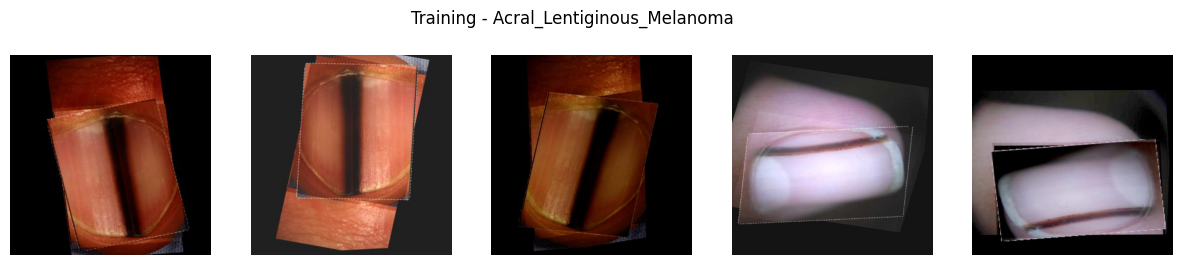

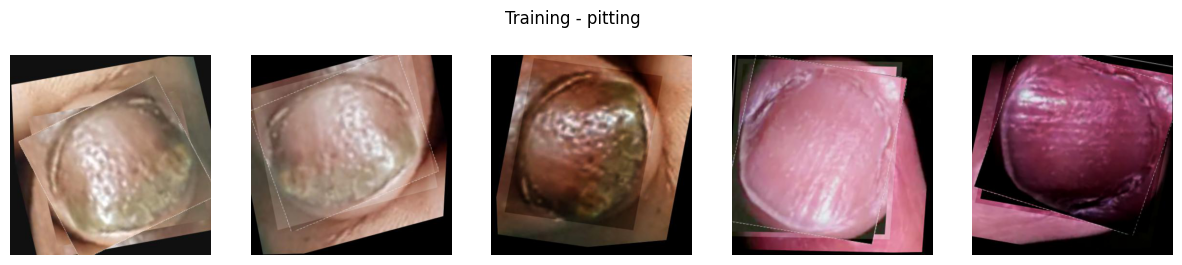

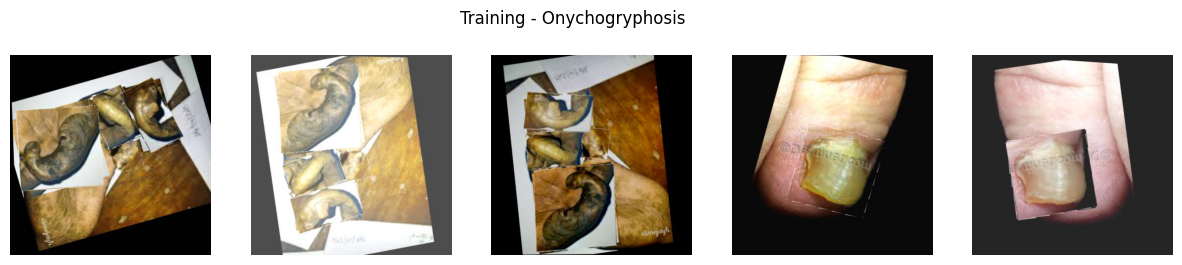

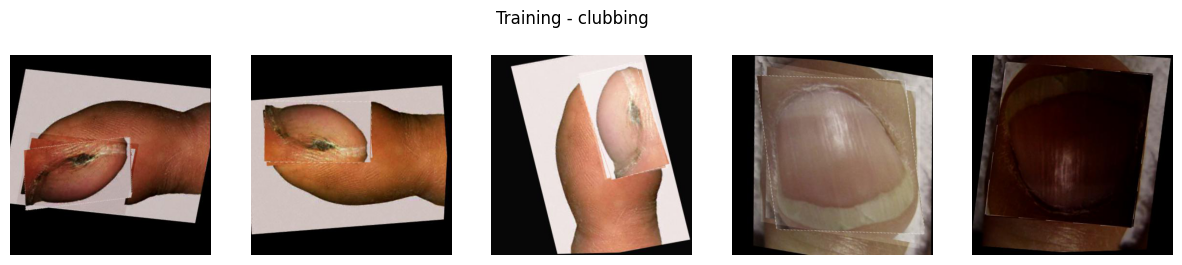

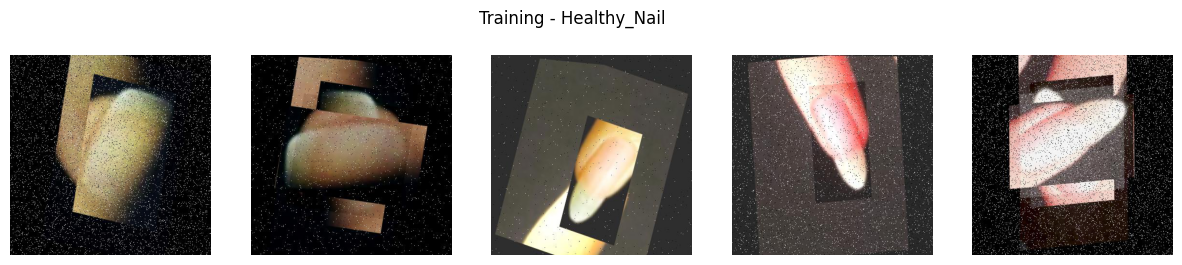

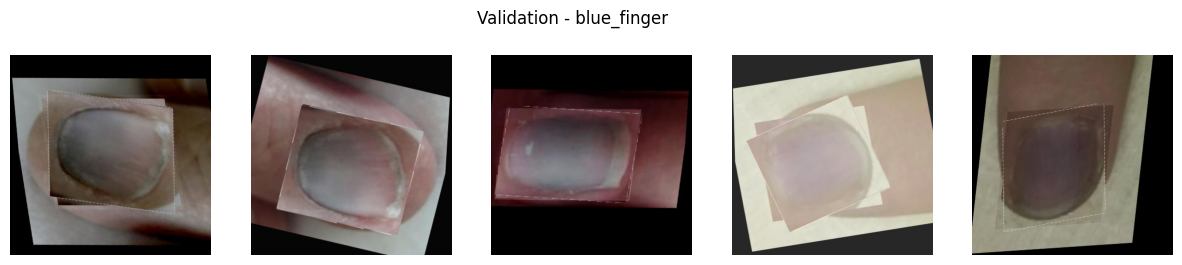

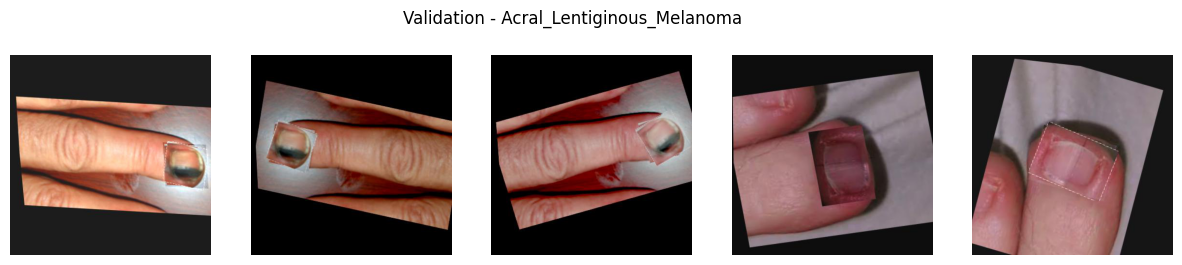

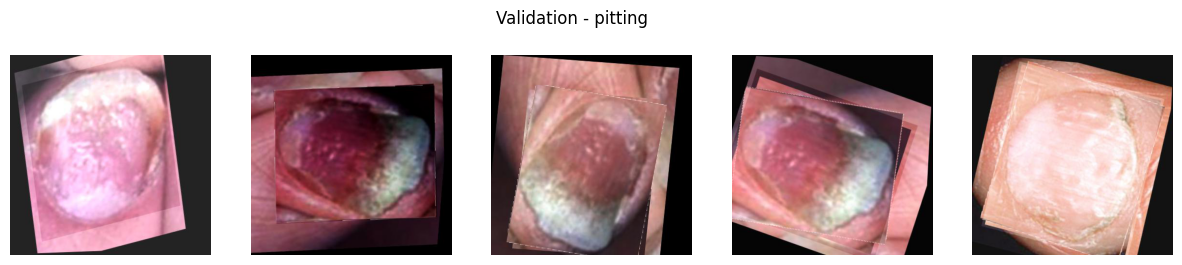

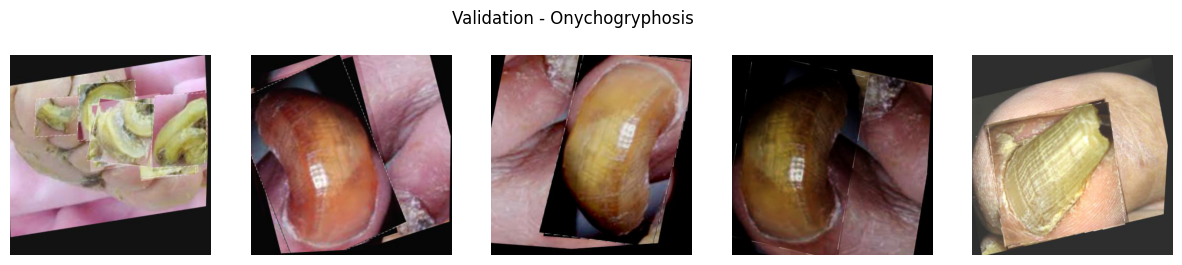

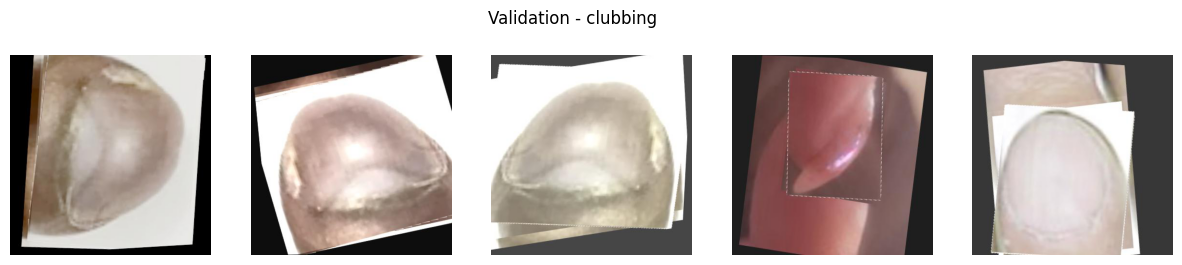

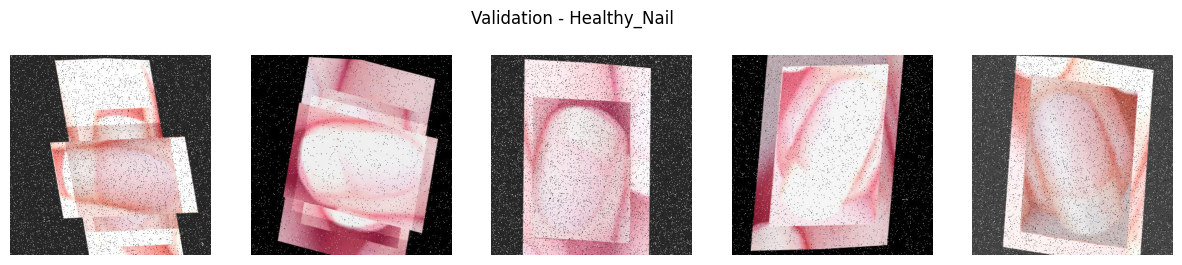

In [6]:
def display_images_from_folder(folder_path, title):
    """Display up to 5 images from a specified folder."""
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    image_files = image_files[:5]  

    plt.figure(figsize=(15, 3)) 
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(folder_path, image_file)
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

for folder in folders:
    folder_path = os.path.join(train_path, folder)
    display_images_from_folder(folder_path, f'Training - {folder}')

for folder in folders:
    folder_path = os.path.join(validation_path, folder)
    display_images_from_folder(folder_path, f'Validation - {folder}')

In [7]:
def preprocess_image(image_path, size=(128, 128)):
    """Load, resize, and normalize an image."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size)
    img = img / 255.0  
    return img

def save_image(image, save_path):
    """Save a preprocessed image."""
    image = (image * 255).astype(np.uint8)  
    img_pil = Image.fromarray(image)
    img_pil.save(save_path)

def preprocess_and_save_images(folder_path, save_dir, size=(128, 128)):
    """Preprocess and save images from a folder."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            preprocessed_img = preprocess_image(img_path, size)
            save_path = os.path.join(save_dir, filename)
            save_image(preprocessed_img.numpy(), save_path)

In [8]:
preprocess_and_save_images(train_path, train_path)
preprocess_and_save_images(validation_path, validation_path)

In [9]:
def create_image_dataset(directory, img_size=(128, 128), batch_size=32):
    """Create a TensorFlow dataset from a directory of images."""
    datagen = ImageDataGenerator(rescale=1.0/255) 
    
    dataset = datagen.flow_from_directory(
        directory,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',  
        shuffle=True
    )
    
    return dataset

train_dataset = create_image_dataset(train_path)
val_dataset = create_image_dataset(validation_path)

Found 3744 images belonging to 6 classes.
Found 91 images belonging to 6 classes.


In [10]:
def create_model(input_shape, num_classes):
    """Create a CNN model for image classification."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [11]:
input_shape = (128, 128, 3)  
num_classes = len(train_dataset.class_indices)

In [12]:
model = create_model(input_shape, num_classes)

C:\Users\HP\anaconda3\envs\abhijitg_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used.")
else:
    print("No GPU found, using CPU.")

No GPU found, using CPU.


In [14]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,  
    verbose=1
)

C:\Users\HP\anaconda3\envs\abhijitg_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.2545 - loss: 1.6892 - val_accuracy: 0.4286 - val_loss: 1.2424
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step - accuracy: 0.3821 - loss: 1.4101 - val_accuracy: 0.5385 - val_loss: 1.1474
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 196ms/step - accuracy: 0.4638 - loss: 1.2718 - val_accuracy: 0.5714 - val_loss: 1.0547
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - accuracy: 0.5027 - loss: 1.2122 - val_accuracy: 0.5165 - val_loss: 1.1429
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 198ms/step - accuracy: 0.5220 - loss: 1.1485 - val_accuracy: 0.5604 - val_loss: 1.0892
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - accuracy: 0.5667 - loss: 1.1331 - val_accuracy: 0.6154 - val_loss: 1.0255
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step - accuracy: 0.5911 - loss: 1.0219 - val_accuracy: 0.6484 - val_loss: 0.9585
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step - accuracy: 0.6317 - loss: 0

In [16]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(Fore.GREEN + f"Validation Loss => {val_loss}")
print(Fore.BLUE + f"Validation Accuracy => {val_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6812 - loss: 1.6718
Validation Loss => 1.657081127166748
Validation Accuracy => 0.6593406796455383


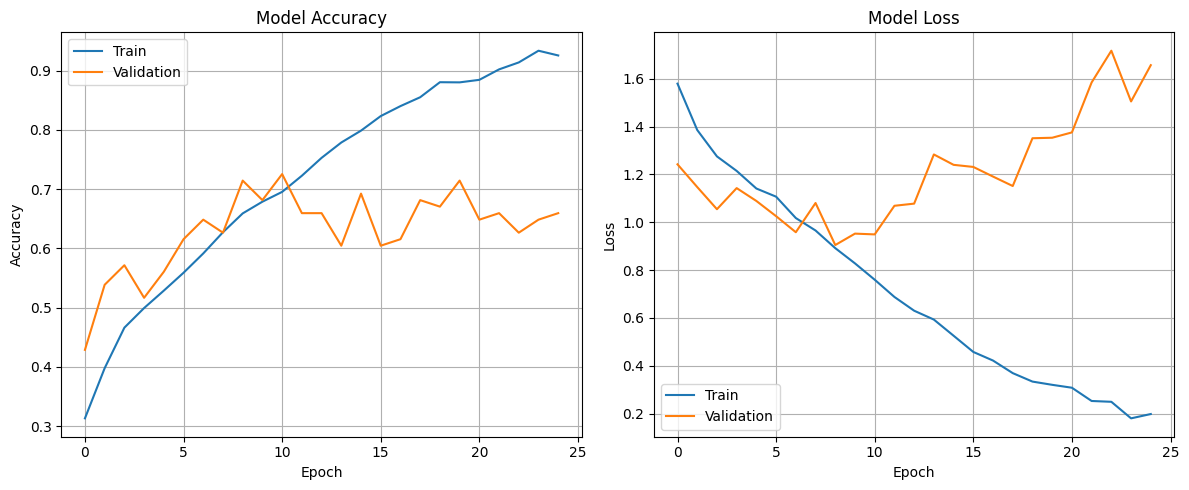

In [17]:
def plot_history(history):
    """Plot the training history."""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_history(history)